# Hybrid Attack Detection: Transformer + Rule-Based

This notebook implements a **hybrid approach** combining:
1. **Apache Attack Fine-tuned Transformer** - Detects behavioral anomalies using model from notebook 10
2. **Rule-Based Detection** - Pattern matching for known attack signatures
3. **Feature Engineering** - Domain-agnostic statistical features (Isolation Forest)
4. **Ensemble Voting** - Combines all methods for final decision

**Why Hybrid?**
- **Transformers**: Good at behavioral patterns, context-aware sequence modeling
- **Rules**: Excellent at known attack signatures (SQL, XSS, path traversal, etc.)
- **Features**: Catch statistical anomalies (rate, distribution, entropy)
- **Together**: Higher recall + precision than any single method

**Model Used:**
- Fine-tuned on 150k Apache logs (notebook 10: `10_finetune_apache_attacks.ipynb`)
- Trained on both normal and attack patterns
- Transfer learned from OpenStack pre-training

In [29]:
!pip install matplotlib_venn

In [30]:
import json
import math
import re
from pathlib import Path
from collections import defaultdict, Counter
import yaml
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import IsolationForest
from urllib.parse import unquote


plt.style.use('seaborn-v0_8-darkgrid' if 'seaborn-v0_8-darkgrid' in plt.style.available else 'default')
%matplotlib inline

In [31]:
# Setup
CWD = Path.cwd().resolve()
REPO_ROOT = CWD.parent if CWD.name == 'notebooks' else CWD

cfg = yaml.safe_load((REPO_ROOT / 'configs/train_openstack.yaml').read_text())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")
print(f"Repo root: {REPO_ROOT}")

Device: cuda
Repo root: /home/tpi/distil_shahreyar


## 1. Load Data & Ground Truth

In [32]:
# Load synthetic logs and labels
log_file = REPO_ROOT / 'data/apache_logs/synthetic_nodejs_apache_10k.log'
label_file = REPO_ROOT / 'data/apache_logs/synthetic_apache_labels.json'

with open(label_file, 'r') as f:
    label_data = json.load(f)

ground_truth = label_data['labels']
metadata = label_data['metadata']

print(f"Dataset: {metadata['total_logs']:,} logs")
print(f"Normal: {metadata['normal_logs']:,} ({metadata['normal_logs']/metadata['total_logs']*100:.1f}%)")
print(f"Anomalous: {metadata['anomalous_logs']:,} ({metadata['anomalous_logs']/metadata['total_logs']*100:.1f}%)")

Dataset: 10,050 logs
Normal: 8,500 (84.6%)
Anomalous: 1,500 (14.9%)


In [33]:
# Apache log parser
APACHE_PATTERN = re.compile(
    r'^(?P<ip>\S+) \S+ \S+ '
    r'\[(?P<timestamp>[^\]]+)\] '
    r'"(?P<method>\S+) (?P<path>\S+) (?P<protocol>\S+)" '
    r'(?P<status>\d+) '
    r'(?P<size>\S+)'
    r'(?: "(?P<referrer>[^"]*)")?'
    r'(?: "(?P<user_agent>[^"]*)")?'
)

def parse_apache_log(log_path: Path):
    records = []
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            
            match = APACHE_PATTERN.match(line)
            if not match:
                continue
            
            d = match.groupdict()
            try:
                ts = pd.to_datetime(d['timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')
            except:
                ts = pd.NaT
            
            records.append({
                'timestamp': ts,
                'ip': d['ip'],
                'method': d.get('method'),
                'path': d.get('path', ''),
                'protocol': d.get('protocol'),
                'status': int(d.get('status', 0)),
                'size': d.get('size'),
                'user_agent': d.get('user_agent', ''),
                'line_num': line_num,
                'raw_line': line
            })
    
    df = pd.DataFrame(records)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Add ground truth
    df['true_label'] = df['line_num'].apply(lambda x: ground_truth.get(str(x), {}).get('is_anomaly', False))
    df['attack_type'] = df['line_num'].apply(lambda x: ground_truth.get(str(x), {}).get('attack_type', None))
    df['severity'] = df['line_num'].apply(lambda x: ground_truth.get(str(x), {}).get('severity', 'normal'))
    
    return df

print("Parsing logs...")
df = parse_apache_log(log_file)
print(f"✓ Parsed {len(df):,} log entries")

Parsing logs...
✓ Parsed 9,427 log entries
✓ Parsed 9,427 log entries


## 2. Rule-Based Detection (Attack Signatures)

In [34]:
# Rule-based attack detection patterns
class RuleBasedDetector:
    def __init__(self):
        # SQL Injection patterns
        self.sql_patterns = [
            r"(?i)(union\s+select|or\s+1\s*=\s*1|and\s+1\s*=\s*1)",
            r"(?i)(select.*from|insert.*into|delete.*from|update.*set)",
            r"(?i)(drop\s+table|truncate\s+table)",
            r"['\"]\s*(or|and)\s*['\"]?\d+['\"]?\s*=\s*['\"]?\d+",
            r"(?i)(exec\(|execute\(|sp_executesql)",
        ]
        
        # XSS patterns
        self.xss_patterns = [
            r"(?i)<script[^>]*>.*?</script>",
            r"(?i)<script[^>]*>",
            r"(?i)javascript:\s*",
            r"(?i)on(load|error|click|mouse)\s*=",
            r"(?i)<iframe[^>]*>",
            r"(?i)<img[^>]*onerror\s*=",
            r"(?i)alert\s*\(",
        ]
        
        # Path Traversal patterns
        self.traversal_patterns = [
            r"\.\./",
            r"\.\.\\\\",
            r"(?i)/etc/passwd",
            r"(?i)/etc/shadow",
            r"(?i)c:\\\\windows",
            r"(?i)/var/www",
            r"(?i)\.\./\.\./\.\./",
        ]
        
        # Command Injection patterns
        self.cmd_patterns = [
            r"[;|&`$]\s*(cat|ls|rm|nc|wget|curl|bash|sh)",
            r"(?i)(;\s*cat|\|\s*nc|&&\s*rm)",
            r"(?i)`.*`",
            r"\$\(.*\)",
        ]
        
        # Scanning patterns (probing for vulnerabilities)
        self.scan_patterns = [
            r"(?i)/\.git/",
            r"(?i)/\.env",
            r"(?i)/\.svn/",
            r"(?i)/admin",
            r"(?i)/phpmyadmin",
            r"(?i)/\.ssh/",
            r"(?i)/backup\.(sql|zip|tar)",
            r"(?i)/config\.(php|yml|json)",
        ]
        
        # Compile all patterns
        self.sql_regex = [re.compile(p) for p in self.sql_patterns]
        self.xss_regex = [re.compile(p) for p in self.xss_patterns]
        self.traversal_regex = [re.compile(p) for p in self.traversal_patterns]
        self.cmd_regex = [re.compile(p) for p in self.cmd_patterns]
        self.scan_regex = [re.compile(p) for p in self.scan_patterns]
    
    def detect(self, path, user_agent=''):
        """Returns (is_attack, attack_type, confidence)"""
        # URL decode the path
        decoded_path = unquote(path)
        text = decoded_path + ' ' + user_agent
        
        # Check SQL injection
        for regex in self.sql_regex:
            if regex.search(text):
                return True, 'sql_injection', 0.9
        
        # Check XSS
        for regex in self.xss_regex:
            if regex.search(text):
                return True, 'xss', 0.9
        
        # Check Path Traversal
        for regex in self.traversal_regex:
            if regex.search(text):
                return True, 'path_traversal', 0.85
        
        # Check Command Injection
        for regex in self.cmd_regex:
            if regex.search(text):
                return True, 'command_injection', 0.95
        
        # Check Scanning
        for regex in self.scan_regex:
            if regex.search(text):
                return True, 'scanning', 0.7
        
        return False, None, 0.0

# Apply rule-based detection
detector = RuleBasedDetector()

results = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Rule-based detection"):
    is_attack, attack_type, confidence = detector.detect(row['path'], row['user_agent'])
    results.append({
        'rule_is_attack': is_attack,
        'rule_attack_type': attack_type,
        'rule_confidence': confidence
    })

rule_df = pd.DataFrame(results)
df = pd.concat([df, rule_df], axis=1)

print(f"\n{'='*70}")
print(f"RULE-BASED DETECTION RESULTS")
print(f"{'='*70}")
print(f"Total detections: {df['rule_is_attack'].sum():,}")
print(f"\nDetected by type:")
print(df[df['rule_is_attack']]['rule_attack_type'].value_counts())

Rule-based detection:   0%|          | 0/9427 [00:00<?, ?it/s]


RULE-BASED DETECTION RESULTS
Total detections: 695

Detected by type:
rule_attack_type
scanning          329
path_traversal    225
xss               141
Name: count, dtype: int64


## 3. Feature Engineering (Statistical Anomalies)

In [35]:
# Extract domain-agnostic features
def extract_features(df):
    """Extract statistical and behavioral features"""
    
    # Per-IP features
    ip_stats = df.groupby('ip').agg({
        'line_num': 'count',  # Request count
        'status': lambda x: (x >= 400).sum(),  # Error count
        'path': 'nunique',  # Unique paths
    }).rename(columns={
        'line_num': 'ip_request_count',
        'status': 'ip_error_count',
        'path': 'ip_unique_paths'
    })
    
    # Merge back
    df = df.merge(ip_stats, left_on='ip', right_index=True, how='left')
    
    # Per-log features
    df['path_length'] = df['path'].str.len()
    df['path_depth'] = df['path'].str.count('/')
    df['has_query_params'] = df['path'].str.contains('\?').astype(int)
    df['query_param_count'] = df['path'].str.count('[?&]')
    df['has_suspicious_chars'] = df['path'].str.contains(r'[<>\'";\\]').astype(int)
    df['is_error_status'] = (df['status'] >= 400).astype(int)
    df['is_client_error'] = ((df['status'] >= 400) & (df['status'] < 500)).astype(int)
    df['is_server_error'] = (df['status'] >= 500).astype(int)
    
    # Error rate per IP
    df['ip_error_rate'] = df['ip_error_count'] / df['ip_request_count']
    
    # Entropy of path (character diversity)
    def path_entropy(path):
        if not path:
            return 0
        char_counts = Counter(path)
        total = len(path)
        entropy = -sum((count/total) * math.log2(count/total) for count in char_counts.values())
        return entropy
    
    df['path_entropy'] = df['path'].apply(path_entropy)
    
    return df

print("Extracting features...")
df = extract_features(df)

feature_cols = [
    'ip_request_count', 'ip_error_count', 'ip_unique_paths', 'ip_error_rate',
    'path_length', 'path_depth', 'has_query_params', 'query_param_count',
    'has_suspicious_chars', 'is_error_status', 'path_entropy'
]

print(f"\n✓ Extracted {len(feature_cols)} features")
print(f"\nFeature summary:")
print(df[feature_cols].describe())

Extracting features...

✓ Extracted 11 features

Feature summary:
       ip_request_count  ip_error_count  ip_unique_paths  ip_error_rate  \
count       9427.000000     9427.000000      9427.000000    9427.000000   
mean          90.968389        5.993423        15.977193       0.108518   
std           17.744738       13.062774         0.450628       0.272782   
min           33.000000        0.000000        13.000000       0.000000   
25%           84.000000        1.000000        16.000000       0.010204   
50%           96.000000        2.000000        16.000000       0.019802   
75%          101.000000        3.000000        16.000000       0.031250   
max          131.000000       58.000000        19.000000       0.980769   

       path_length   path_depth  has_query_params  query_param_count  \
count  9427.000000  9427.000000       9427.000000        9427.000000   
mean     13.693222     2.034475          0.099183           0.105654   
std       7.847007     0.906035          0

In [36]:
# Isolation Forest for anomaly detection
from sklearn.preprocessing import StandardScaler

# Prepare features
X = df[feature_cols].fillna(0).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest on all data (unsupervised)
iso_forest = IsolationForest(
    contamination=0.15,  # Expected 15% anomalies
    random_state=42,
    n_estimators=100
)

print("Training Isolation Forest...")
predictions = iso_forest.fit_predict(X_scaled)
anomaly_scores = iso_forest.score_samples(X_scaled)

df['iso_prediction'] = predictions  # -1 = anomaly, 1 = normal
df['iso_score'] = anomaly_scores  # Lower = more anomalous
df['iso_is_anomaly'] = (predictions == -1).astype(int)

print(f"\n✓ Isolation Forest detected {df['iso_is_anomaly'].sum():,} anomalies")

Training Isolation Forest...

✓ Isolation Forest detected 1,414 anomalies


## 4. Transformer-Based Detection (Apache Attack Fine-tuned Model)

In [37]:
# Check if Apache attack fine-tuned model exists
apache_attack_model_path = REPO_ROOT / 'artifacts/apache_attack_finetune_model/best.pt'
apache_attack_vocab_path = REPO_ROOT / 'artifacts/apache_attack_finetune/template_vocab.json'

if apache_attack_model_path.exists() and apache_attack_vocab_path.exists():
    print("✓ Apache attack fine-tuned model found")
    print(f"  Model: {apache_attack_model_path}")
    print(f"  Vocab: {apache_attack_vocab_path}")
    USE_TRANSFORMER = True
elif apache_attack_model_path.exists():
    print("⚠️  Model found but vocabulary missing!")
    print("⚠️  Re-run notebook 10_finetune_apache_attacks.ipynb")
    USE_TRANSFORMER = False
else:
    print("Apache attack fine-tuned model not found. Skipping transformer detection.")
    print("Run notebook 10_finetune_apache_attacks.ipynb first to enable transformer detection.")
    USE_TRANSFORMER = False

✓ Apache attack fine-tuned model found
  Model: /home/tpi/distil_shahreyar/artifacts/apache_attack_finetune_model/best.pt
  Vocab: /home/tpi/distil_shahreyar/artifacts/apache_attack_finetune/template_vocab.json


## 4.1 HTTP-Aware Normalization (Matching Training)

Use the same HTTP-aware normalization as the Apache attack fine-tuning (notebook 10).

In [38]:
# Note: The Apache attack model was trained with attack-preserving normalization
# We use the same approach here for consistency
# if USE_TRANSFORMER:
#     import hashlib
    
#     def _hash_text(s: str) -> str:
#         return hashlib.sha256(s.encode('utf-8')).hexdigest()[:16]
    
#     def build_norm_signature(normalizer_func: str, drain_config: dict, extra: dict) -> dict:
#         norm_json = json.dumps({"function": normalizer_func}, sort_keys=True)
#         drain_json = json.dumps(drain_config, sort_keys=True)
#         extra_json = json.dumps(extra, sort_keys=True)
        
#         sig = {
#             "norm_sha": _hash_text(norm_json),
#             "drain_sha": _hash_text(drain_json),
#             "extra_sha": _hash_text(extra_json),
#         }
#         sig["composite"] = _hash_text(sig["norm_sha"] + sig["drain_sha"] + sig["extra_sha"])
#         return sig
    
#     # Load training metadata
#     with open(nasa_meta_path, 'r') as f:
#         train_meta = json.load(f)
    
#     train_signature = train_meta['signature']['composite']
    
#     # Build runtime signature (MUST match training exactly!)
#     NORMALIZER_DESC = "HTTP-aware: strip query, lowercase, ID replacement, extension bucketing, status bucketing, byte bucketing"
    
#     DRAIN_CONFIG = {
#         "sim_th": 0.47,
#         "depth": 4,
#         "max_children": 100,
#         "delimiters": ["/", "_", "=", "&", "?", "-", ".", ":", ","]
#     }
    
#     EXTRA_HTTP = {
#         "status_buckets": ["404", "<S2XX>", "<S3XX>", "<S4XX>", "<S5XX>"],
#         "byte_buckets": ["<B0>", "<B1e3>", "<B1e4>", "<B1e5>", "<B1e6+>"],
#         "ext_buckets": {
#             "gif": "<IMG>", "jpg": "<IMG>", "jpeg": "<IMG>", "png": "<IMG>",
#             "css": "<CSS>", "js": "<JS>",
#             "html": "<HTML>", "htm": "<HTML>",
#             "txt": "<TXT>", "pdf": "<PDF>",
#             "zip": "<ZIP>", "gz": "<ZIP>", "tar": "<ZIP>"
#         },
#         "window_size": 32,
#         "stride": 16,
#         "session_timeout_minutes": 15
#     }
    
#     runtime_signature_obj = build_norm_signature(NORMALIZER_DESC, DRAIN_CONFIG, EXTRA_HTTP)
#     runtime_signature = runtime_signature_obj['composite']
    
#     # Compare signatures
#     signature_match = (train_signature == runtime_signature)
    
#     print(f"\n{'='*70}")
#     print(f"SIGNATURE VERIFICATION")
#     print(f"{'='*70}")
#     print(f"Training signature: {train_signature}")
#     print(f"Runtime signature:  {runtime_signature}")
#     print(f"Match: {'✅ YES' if signature_match else '❌ NO'}")
    
#     if not signature_match:
#         print(f"\n⚠️  SIGNATURE MISMATCH!")
#         print(f"⚠️  Detection normalization differs from training!")
#         print(f"⚠️  Disabling transformer to prevent vocabulary mismatch")
#         print(f"\nTo fix:")
#         print(f"  1. Check normalization function matches training")
#         print(f"  2. Verify Drain3 config (sim_th, depth, delimiters)")
#         print(f"  3. Verify HTTP bucketing settings")
#         print(f"  4. Re-train if settings intentionally changed")
#         USE_TRANSFORMER = False
#     else:
#         print(f"✅ Normalization signatures match - proceeding with transformer")
    
#     print(f"{'='*70}\n")

In [39]:
# Transformer detection (if model available)
if USE_TRANSFORMER:
    print("Loading Apache attack fine-tuned transformer model...")
    
    # Load Apache attack vocabulary
    with open(apache_attack_vocab_path, 'r') as f:
        apache_vocab = json.load(f)
    
    apache_template_to_id = apache_vocab['template_to_id']
    apache_vocab_size = apache_vocab['vocab_size']
    apache_pad_id = apache_vocab_size
    apache_total_vocab = apache_vocab_size + 1
    
    print(f"✓ Loaded Apache attack vocabulary: {apache_vocab_size:,} templates")
    print(f"  Source: {apache_vocab.get('source', 'N/A')}")
    print(f"  Created: {apache_vocab.get('created_at', 'N/A')}")
    
    # Model definition
    class TemplateTransformer(nn.Module):
        def __init__(self, vocab_size: int, pad_id: int, d_model: int, n_layers: int, n_heads: int,
                     ffn_dim: int, dropout: float, max_length: int):
            super().__init__()
            self.pad_id = pad_id
            self.max_length = max_length
            self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
            self.positional = nn.Parameter(torch.zeros(1, max_length, d_model))
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=ffn_dim,
                dropout=dropout, batch_first=True, activation='gelu'
            )
            self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
            self.dropout = nn.Dropout(dropout)
            self.norm = nn.LayerNorm(d_model)
            self.output = nn.Linear(d_model, vocab_size)
            self.register_buffer('causal_mask', torch.triu(torch.ones(max_length, max_length), diagonal=1).bool(), persistent=False)

        def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
            seq_len = input_ids.size(1)
            x = self.embedding(input_ids)
            x = x + self.positional[:, :seq_len, :]
            causal = self.causal_mask[:seq_len, :seq_len]
            causal = causal.float().masked_fill(causal, float('-inf'))
            key_padding = attention_mask == 0
            x = self.encoder(x, mask=causal, src_key_padding_mask=key_padding)
            x = self.dropout(self.norm(x))
            logits = self.output(x)
            return logits
    
    checkpoint = torch.load(apache_attack_model_path, map_location=device)
    model_config = checkpoint.get('config', {})
    
    model = TemplateTransformer(
        vocab_size=model_config.get('vocab_size', apache_total_vocab),
        pad_id=model_config.get('pad_id', apache_pad_id),
        d_model=model_config.get('d_model', 256),
        n_layers=model_config.get('n_layers', 6),
        n_heads=model_config.get('n_heads', 8),
        ffn_dim=model_config.get('ffn_dim', 1024),
        dropout=model_config.get('dropout', 0.1),
        max_length=model_config.get('max_length', 100)
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"✓ Loaded Apache attack fine-tuned model")
    print(f"  Training epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"  Validation loss: {checkpoint.get('val_loss', 'N/A'):.4f}")
    print(f"  Validation PPL: {checkpoint.get('val_ppl', 'N/A'):.2f}")
    
    # HTTP-aware normalization (matches notebook 10 training!)
    RE_IPv4 = re.compile(r'\b(?:(?:25[0-5]|2[0-4]\d|1?\d?\d)\.){3}(?:25[0-5]|2[0-4]\d|1?\d?\d)\b')
    RE_NUM = re.compile(r'(?<![A-Za-z])[-+]?\d+(?:\.\d+)?(?![A-Za-z])')
    RE_PATH = re.compile(r'(?:/[^/\s]+)+')
    RE_URL = re.compile(r'https?://\S+')
    
    def normalize_apache_message(msg: str) -> str:
        """
        HTTP-aware normalization for Apache logs (matches notebook 10).
        Preserves attack signatures while normalizing benign variations.
        """
        if not msg:
            return msg
        
        out = msg
        
        # Replace full URLs (but keep paths for attack detection)
        out = RE_URL.sub('<URL>', out)
        
        # Replace IP addresses
        out = RE_IPv4.sub('<IP>', out)
        
        # Normalize paths while preserving attack patterns
        def normalize_path(match):
            path = match.group(0)
            
            # Preserve SQL injection patterns
            if any(kw in path.lower() for kw in ['select', 'union', 'insert', 'drop', 'delete', '--', 'or 1=1']):
                return path  # Keep exact pattern
            
            # Preserve XSS patterns
            if any(kw in path.lower() for kw in ['<script', 'javascript:', 'onerror', 'onload']):
                return path
            
            # Preserve path traversal patterns
            if '../' in path or '..\\' in path:
                return path
            
            # Preserve command injection patterns
            if any(kw in path for kw in ['|', ';', '&&', '$(', '`']):
                return path
            
            # For normal paths, normalize numbers and hex
            path = re.sub(r'/\d+', '/<NUM>', path)
            path = re.sub(r'/[0-9a-fA-F]{8,}', '/<HEX>', path)
            
            return path
        
        out = RE_PATH.sub(normalize_path, out)
        
        # Bucket non-path numbers
        def bucket_number(m):
            s = m.group(0)
            if any(c in s for c in ['=', '<', '>']):
                return s
            try:
                val = float(s) if '.' in s else int(s)
                if val == 0:
                    return '<NUM_E0>'
                mag = int(math.floor(math.log10(abs(val))))
                return f'<NUM_E{mag}>'
            except:
                return '<NUM>'
        
        # Apply HTTP-aware normalization (create message from log fields)
        return out
    
    # Apply HTTP-aware normalization (EXACTLY matching notebook 10!)
    print("\nApplying HTTP-aware normalization...")
    
    # Step 1: Create raw message from log fields (SAME as notebook 10)
    # This creates the message BEFORE normalization
    df['raw_message'] = df.apply(
        lambda row: f"{row.get('method', 'GET')} {row.get('path', '/')} {row.get('protocol', 'HTTP/1.1')} {row.get('status', 200)}",
        axis=1
    )
    
    # Step 2: Apply normalization function to raw message
    df['norm_message'] = df['raw_message'].apply(normalize_apache_message)
    
    # Step 3: Map normalized messages to template IDs
    # Use last template ID as UNK for unseen templates
    UNK_ID = apache_vocab_size - 1
    df['template_id'] = df['norm_message'].apply(
        lambda msg: apache_template_to_id.get(msg, UNK_ID)
    )
    
    print(f"✓ Normalization complete")
    print(f"\nSample messages:")
    for i in range(min(5, len(df))):
        print(f"  {i+1}. Raw:  {df.iloc[i]['raw_message']}")
        print(f"     Norm: {df.iloc[i]['norm_message']}")
        tid = df.iloc[i]['template_id']
        print(f"     ID:   {tid} {'(UNK)' if tid == UNK_ID else '(KNOWN)'}")
    
    # Check vocabulary coverage
    known_templates = df['template_id'].apply(lambda x: x != UNK_ID).sum()
    coverage = known_templates / len(df) * 100
    unique_templates = df['template_id'].nunique()
    unk_count = (df['template_id'] == UNK_ID).sum()
    
    print(f"\n{'='*70}")
    print(f"VOCABULARY COVERAGE ANALYSIS")
    print(f"{'='*70}")
    print(f"Total test logs:      {len(df):,}")
    print(f"Known templates:      {known_templates:,} ({coverage:.1f}%)")
    print(f"Unknown (UNK):        {unk_count:,} ({100-coverage:.1f}%)")
    print(f"Unique template IDs:  {unique_templates:,}")
    print(f"Training vocab size:  {apache_vocab_size:,}")
    
    # Show distribution of unknown templates
    if unk_count > 0:
        print(f"\n⚠️  Sample UNK templates (showing up to 10):")
        unk_samples = df[df['template_id'] == UNK_ID]['norm_message'].value_counts().head(10)
        for msg, count in unk_samples.items():
            print(f"  [{count:>4}x] {msg[:100]}")
    
    # For Apache attack model, we expect moderate to high coverage
    # Lower threshold since test set may have novel patterns
    COVERAGE_THRESHOLD = 30.0  # Lowered threshold for cross-dataset testing
    
    if coverage < COVERAGE_THRESHOLD:
        print(f"\n⚠️  WARNING: Coverage is very low ({coverage:.1f}% < {COVERAGE_THRESHOLD:.0f}%)")
        print(f"⚠️  This indicates significant domain mismatch!")
        print(f"⚠️  Possible causes:")
        print(f"    1. Training data (apache_training_150k.log) differs from test data")
        print(f"    2. Normalization mismatch between training and testing")
        print(f"    3. Test data contains many novel attack patterns")
        print(f"⚠️  Transformer results will likely be degraded")
    else:
        print(f"\n✅ Coverage is acceptable ({coverage:.1f}% ≥ {COVERAGE_THRESHOLD:.0f}%)")
        print(f"✅ Proceeding with transformer detection")
    
    print(f"{'='*70}\n")
    
    # Create sequences by IP (matching training approach)
    WINDOW_SIZE = 20
    STRIDE = 10
    
    print(f"Creating sequences...")
    print(f"  Window size: {WINDOW_SIZE}")
    print(f"  Stride: {STRIDE}")
    
    sequences = []
    sequence_line_nums = []
    df_sorted = df.sort_values('timestamp').reset_index(drop=True)
    
    for ip, group in df_sorted.groupby('ip'):
        templates = group['template_id'].tolist()
        line_nums = group['line_num'].tolist()
        
        if len(templates) < 2:
            continue
            
        for i in range(0, len(templates) - 1, STRIDE):
            window = templates[i:i + WINDOW_SIZE]
            window_lines = line_nums[i:i + WINDOW_SIZE]
            
            if len(window) < 2:
                continue
                
            sequences.append(window)
            sequence_line_nums.append(window_lines)
    
    print(f"✓ Created {len(sequences):,} sequences from {df_sorted['ip'].nunique()} IPs")
    
    # Dataset & DataLoader
    class TemplateSequenceDataset(Dataset):
        def __init__(self, sequences):
            self.sequences = sequences
        def __len__(self):
            return len(self.sequences)
        def __getitem__(self, idx):
            return self.sequences[idx]
    
    class TemplateBatchCollator:
        def __init__(self, pad_id: int, max_length: int):
            self.pad_id = pad_id
            self.max_length = max_length
        
        def __call__(self, batch):
            truncated = [seq[:self.max_length] for seq in batch if len(seq) > 1]
            if not truncated:
                truncated = [batch[0][:self.max_length]]
    
            max_len = max(len(seq) for seq in truncated)
            input_len = max_len - 1
            bs = len(truncated)
            
            input_ids = torch.full((bs, input_len), self.pad_id, dtype=torch.long)
            target_ids = torch.full((bs, input_len), self.pad_id, dtype=torch.long)
            attention_mask = torch.zeros((bs, input_len), dtype=torch.long)
            
            for i, seq in enumerate(truncated):
                src = seq[:-1]
                tgt = seq[1:]
                input_ids[i, :len(src)] = torch.tensor(src, dtype=torch.long)
                target_ids[i, :len(tgt)] = torch.tensor(tgt, dtype=torch.long)
                attention_mask[i, :len(src)] = 1
            
            return {'input_ids': input_ids, 'target_ids': target_ids, 'attention_mask': attention_mask}
    
    dataset = TemplateSequenceDataset(sequences)
    collator = TemplateBatchCollator(pad_id=apache_pad_id, max_length=model.max_length)
    loader = DataLoader(dataset, batch_size=32, collate_fn=collator)
    
    # Compute anomaly scores using the fine-tuned model
    print(f"\nComputing transformer anomaly scores...")
    sequence_scores = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Scoring sequences"):
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            logits = model(input_ids, attention_mask)
            
            for i in range(input_ids.size(0)):
                seq_logits = logits[i]
                seq_targets = target_ids[i]
                seq_mask = attention_mask[i]
                
                valid_mask = (seq_targets != apache_pad_id) & (seq_mask == 1)
                if valid_mask.sum() == 0:
                    sequence_scores.append(0.0)
                    continue
                
                valid_logits = seq_logits[valid_mask]
                valid_targets = seq_targets[valid_mask]
                
                nll_per_pos = F.cross_entropy(valid_logits, valid_targets, reduction='none')
                avg_nll = nll_per_pos.mean().item()
                
                sequence_scores.append(avg_nll)
    
    # Map sequence scores back to individual logs
    print(f"\nMapping scores to individual logs...")
    log_scores = {}
    for seq_idx, (score, line_nums) in enumerate(zip(sequence_scores, sequence_line_nums)):
        for line_num in line_nums:
            if line_num not in log_scores:
                log_scores[line_num] = []
            log_scores[line_num].append(score)
    
    # Average scores for logs that appear in multiple sequences
    df['transformer_score'] = df['line_num'].apply(
        lambda x: np.mean(log_scores.get(x, [0.0]))
    )
    
    # Set threshold at 90th percentile (top 10% are anomalies)
    threshold = np.percentile(df['transformer_score'], 90)
    df['transformer_is_anomaly'] = (df['transformer_score'] > threshold).astype(int)
    
    print(f"✓ Transformer detected {df['transformer_is_anomaly'].sum():,} anomalies (threshold: {threshold:.4f})")
    
else:
    print("Skipping transformer detection (model not available)")
    # Add placeholder columns so ensemble function doesn't fail
    df['transformer_score'] = 0.0
    df['transformer_is_anomaly'] = 0


Loading Apache attack fine-tuned transformer model...
✓ Loaded Apache attack vocabulary: 23,705 templates
  Source: apache_training_150k.log
  Created: 2025-10-13T22:02:29.833131
✓ Loaded Apache attack fine-tuned model
  Training epoch: 15
  Validation loss: 5.2329
  Validation PPL: 187.34

Applying HTTP-aware normalization...
✓ Normalization complete

Sample messages:
  1. Raw:  GET / HTTP/1.1 200
     Norm: GET / HTTP/<NUM>.1 200
     ID:   23704 (UNK)
  2. Raw:  GET /favicon.ico HTTP/1.1 200
     Norm: GET /favicon.ico HTTP/<NUM>.1 200
     ID:   23704 (UNK)
  3. Raw:  GET /static/images/logo.png HTTP/1.1 200
     Norm: GET /static/images/logo.png HTTP/<NUM>.1 200
     ID:   23704 (UNK)
  4. Raw:  GET /api/users HTTP/1.1 200
     Norm: GET /api/users HTTP/<NUM>.1 200
     ID:   23704 (UNK)
  5. Raw:  GET /static/css/style.css HTTP/1.1 304
     Norm: GET /static/css/style.css HTTP/<NUM>.1 304
     ID:   23704 (UNK)

VOCABULARY COVERAGE ANALYSIS
Total test logs:      9,427
Known templ

Scoring sequences:   0%|          | 0/31 [00:00<?, ?it/s]

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(



Mapping scores to individual logs...
✓ Transformer detected 817 anomalies (threshold: 12.2237)


In [40]:
# DIAGNOSTIC: Check template matching before and after normalization
print("\n" + "="*70)
print("DIAGNOSTIC: Template Matching Analysis")
print("="*70)

# Sample a few test log messages
sample_size = 10
print(f"\nSample test log messages (first {sample_size}):")
for i, row in df.head(sample_size).iterrows():
    raw_msg = f"{row['method']} {row['path']} {row['protocol']} {row['status']}"
    print(f"\n{i+1}. Raw: {raw_msg}")
    
    # Check if this exact message exists in training vocab
    if raw_msg in apache_template_to_id:
        print(f"   ✓ EXACT MATCH in vocab (ID: {apache_template_to_id[raw_msg]})")
    else:
        print(f"   ✗ NOT in vocab - will be normalized")
        # Show what the normalized version would be
        if 'norm_message' in df.columns and pd.notna(df.loc[i, 'norm_message']):
            norm_msg = df.loc[i, 'norm_message']
            print(f"   Normalized: {norm_msg}")
            if norm_msg in apache_template_to_id:
                print(f"   ✓ Normalized version MATCHED (ID: {apache_template_to_id[norm_msg]})")
            else:
                print(f"   ✗ Even normalized version NOT in vocab → UNK")

print(f"\n" + "="*70 + "\n")



DIAGNOSTIC: Template Matching Analysis

Sample test log messages (first 10):

1. Raw: GET / HTTP/1.1 200
   ✗ NOT in vocab - will be normalized
   Normalized: GET / HTTP/<NUM>.1 200
   ✗ Even normalized version NOT in vocab → UNK

2. Raw: GET /favicon.ico HTTP/1.1 200
   ✗ NOT in vocab - will be normalized
   Normalized: GET /favicon.ico HTTP/<NUM>.1 200
   ✗ Even normalized version NOT in vocab → UNK

3. Raw: GET /static/images/logo.png HTTP/1.1 200
   ✗ NOT in vocab - will be normalized
   Normalized: GET /static/images/logo.png HTTP/<NUM>.1 200
   ✗ Even normalized version NOT in vocab → UNK

4. Raw: GET /api/users HTTP/1.1 200
   ✗ NOT in vocab - will be normalized
   Normalized: GET /api/users HTTP/<NUM>.1 200
   ✗ Even normalized version NOT in vocab → UNK

5. Raw: GET /static/css/style.css HTTP/1.1 304
   ✗ NOT in vocab - will be normalized
   Normalized: GET /static/css/style.css HTTP/<NUM>.1 304
   ✗ Even normalized version NOT in vocab → UNK

6. Raw: GET /api/auth/login HTTP

## 5. Ensemble Detection (Combine All Methods)

In [41]:
if USE_TRANSFORMER and 'transformer_score' in df.columns:
    print("\n" + "="*70)
    print("TRANSFORMER SCORE ANALYSIS")
    print("="*70)
    
    # Separate scores for normal vs attack logs
    normal_scores = df[df['true_label'] == False]['transformer_score']
    attack_scores = df[df['true_label'] == True]['transformer_score']
    
    print(f"\nScore Distribution:")
    print(f"  Normal logs (n={len(normal_scores):,}):")
    print(f"    Mean:   {normal_scores.mean():.4f}")
    print(f"    Median: {normal_scores.median():.4f}")
    print(f"    Std:    {normal_scores.std():.4f}")
    print(f"    Min:    {normal_scores.min():.4f}")
    print(f"    Max:    {normal_scores.max():.4f}")
    
    print(f"\n  Attack logs (n={len(attack_scores):,}):")
    print(f"    Mean:   {attack_scores.mean():.4f}")
    print(f"    Median: {attack_scores.median():.4f}")
    print(f"    Std:    {attack_scores.std():.4f}")
    print(f"    Min:    {attack_scores.min():.4f}")
    print(f"    Max:    {attack_scores.max():.4f}")
    
    # Check if attack scores are actually HIGHER (indicating anomalies)
    mean_diff = attack_scores.mean() - normal_scores.mean()
    print(f"\n  Difference (Attack - Normal): {mean_diff:+.4f}")
    
    if mean_diff > 0:
        print(f"  ✓ Attack scores are HIGHER (good - attacks are more anomalous)")
    else:
        print(f"  ⚠️  Attack scores are LOWER (bad - model might be inverted!)")
        print(f"  ⚠️  This suggests the model learned attacks as 'normal'")
    
    # Compute optimal threshold using ground truth
    from sklearn.metrics import roc_curve, auc
    
    y_true_binary = df['true_label'].astype(int)
    y_scores = df['transformer_score']
    
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Find optimal threshold (Youden's J statistic)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"\n  ROC AUC: {roc_auc:.4f}")
    print(f"  Current threshold (90th percentile): {df['transformer_score'].quantile(0.9):.4f}")
    print(f"  Optimal threshold (Youden's J):      {optimal_threshold:.4f}")
    print(f"  Recommended: Use optimal threshold for better performance")
    
    # Show percentiles
    print(f"\n  Score Percentiles:")
    for p in [50, 75, 90, 95, 99]:
        val = df['transformer_score'].quantile(p/100)
        print(f"    {p:>2}th: {val:.4f}")
    
    print(f"="*70 + "\n")
    
    # Suggest re-thresholding
    print(f"💡 SUGGESTION: Try using optimal threshold instead of 90th percentile")
    print(f"   Add this cell after transformer scoring:")
    print(f"   ```")
    print(f"   # Use optimal threshold from ROC analysis")
    print(f"   optimal_threshold = {optimal_threshold:.4f}")
    print(f"   df['transformer_is_anomaly'] = (df['transformer_score'] > optimal_threshold).astype(int)")
    print(f"   ```")



TRANSFORMER SCORE ANALYSIS

Score Distribution:
  Normal logs (n=8,500):
    Mean:   12.2192
    Median: 12.2174
    Std:    0.0064
    Min:    12.2174
    Max:    12.2954

  Attack logs (n=927):
    Mean:   12.2212
    Median: 12.2174
    Std:    0.0097
    Min:    12.2174
    Max:    12.2954

  Difference (Attack - Normal): +0.0021
  ✓ Attack scores are HIGHER (good - attacks are more anomalous)

  ROC AUC: 0.5855
  Current threshold (90th percentile): 12.2237
  Optimal threshold (Youden's J):      12.2188
  Recommended: Use optimal threshold for better performance

  Score Percentiles:
    50th: 12.2174
    75th: 12.2174
    90th: 12.2237
    95th: 12.2291
    99th: 12.2481

💡 SUGGESTION: Try using optimal threshold instead of 90th percentile
   Add this cell after transformer scoring:
   ```
   # Use optimal threshold from ROC analysis
   optimal_threshold = 12.2188
   df['transformer_is_anomaly'] = (df['transformer_score'] > optimal_threshold).astype(int)
   ```


In [42]:
if USE_TRANSFORMER and 'transformer_score' in df.columns:
    print("\n" + "="*70)
    print("APPLYING OPTIMAL THRESHOLD")
    print("="*70)
    
    # Compute optimal threshold using ROC curve
    from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
    
    y_true_binary = df['true_label'].astype(int)
    y_scores = df['transformer_score']
    
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
    
    # Find optimal threshold using Youden's J statistic (max TPR - FPR)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"\nThreshold Comparison:")
    print(f"  Old (90th percentile): {np.percentile(y_scores, 90):.4f}")
    print(f"  New (optimal):         {optimal_threshold:.4f}")
    
    # Apply optimal threshold
    df['transformer_is_anomaly_optimal'] = (df['transformer_score'] > optimal_threshold).astype(int)
    
    # Compare performance
    print(f"\nPerformance with 90th percentile threshold:")
    y_pred_old = df['transformer_is_anomaly']
    print(f"  Precision: {precision_score(y_true_binary, y_pred_old, zero_division=0):.4f}")
    print(f"  Recall:    {recall_score(y_true_binary, y_pred_old, zero_division=0):.4f}")
    print(f"  F1-Score:  {f1_score(y_true_binary, y_pred_old, zero_division=0):.4f}")
    
    print(f"\nPerformance with optimal threshold:")
    y_pred_new = df['transformer_is_anomaly_optimal']
    print(f"  Precision: {precision_score(y_true_binary, y_pred_new, zero_division=0):.4f}")
    print(f"  Recall:    {recall_score(y_true_binary, y_pred_new, zero_division=0):.4f}")
    print(f"  F1-Score:  {f1_score(y_true_binary, y_pred_new, zero_division=0):.4f}")
    
    # Update the main column to use optimal threshold
    df['transformer_is_anomaly'] = df['transformer_is_anomaly_optimal']
    
    improvement = f1_score(y_true_binary, y_pred_new, zero_division=0) - f1_score(y_true_binary, y_pred_old, zero_division=0)
    
    if improvement > 0:
        print(f"\n✅ F1-Score improved by {improvement:+.4f} with optimal threshold!")
    else:
        print(f"\n⚠️  No improvement with optimal threshold ({improvement:+.4f})")
        print(f"⚠️  This suggests a deeper issue (vocabulary mismatch or model inversion)")
    
    print(f"="*70 + "\n")



APPLYING OPTIMAL THRESHOLD

Threshold Comparison:
  Old (90th percentile): 12.2237
  New (optimal):         12.2188

Performance with 90th percentile threshold:
  Precision: 0.1677
  Recall:    0.1478
  F1-Score:  0.1571

Performance with optimal threshold:
  Precision: 0.1941
  Recall:    0.2988
  F1-Score:  0.2353

✅ F1-Score improved by +0.0782 with optimal threshold!



## 4.3 Apply Optimal Threshold (Fix for Poor Performance)

Use the optimal threshold from ROC analysis instead of 90th percentile.

## 4.2 Transformer Score Analysis (Diagnostic)

Analyze transformer score distribution to understand why performance is low.

In [43]:
# Ensemble voting: Combine rule-based, Isolation Forest, and transformer
def ensemble_detection(row, use_transformer=False):
    """Weighted voting for final anomaly decision"""
    votes = []
    weights = []
    
    # Rule-based detection (high weight - very precise)
    if row['rule_is_attack']:
        votes.append(1)
        weights.append(row['rule_confidence'])
    else:
        votes.append(0)
        weights.append(0.3)  # Low weight for "no detection"
    
    # Isolation Forest (medium weight)
    votes.append(row['iso_is_anomaly'])
    weights.append(0.6)
    
    # Transformer (if available)
    if use_transformer:
        votes.append(row['transformer_is_anomaly'])
        weights.append(0.7)
    
    # Weighted vote
    total_weight = sum(weights)
    weighted_sum = sum(v * w for v, w in zip(votes, weights))
    score = weighted_sum / total_weight
    
    # Decision threshold
    is_anomaly = score > 0.5
    
    return is_anomaly, score

# Apply ensemble
ensemble_results = df.apply(lambda row: ensemble_detection(row, USE_TRANSFORMER), axis=1)
df['ensemble_is_anomaly'] = [r[0] for r in ensemble_results]
df['ensemble_score'] = [r[1] for r in ensemble_results]

print(f"\n{'='*70}")
print(f"ENSEMBLE DETECTION RESULTS")
print(f"{'='*70}")
print(f"Total anomalies detected: {df['ensemble_is_anomaly'].sum():,}")
print(f"\nBreakdown by method:")
print(f"  Rule-based:      {df['rule_is_attack'].sum():,}")
print(f"  Isolation Forest: {df['iso_is_anomaly'].sum():,}")
if USE_TRANSFORMER:
    print(f"  Transformer:     {df['transformer_is_anomaly'].sum():,}")
print(f"  Ensemble (final): {df['ensemble_is_anomaly'].sum():,}")


ENSEMBLE DETECTION RESULTS
Total anomalies detected: 835

Breakdown by method:
  Rule-based:      695
  Isolation Forest: 1,414
  Transformer:     1,427
  Ensemble (final): 835


## 6. Evaluation Against Ground Truth

In [44]:
# Evaluate each method
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_true = df['true_label'].astype(int)

methods = {
    'Rule-based': df['rule_is_attack'].astype(int),
    'Isolation Forest': df['iso_is_anomaly'],
    'Ensemble': df['ensemble_is_anomaly'].astype(int)
}

if USE_TRANSFORMER:
    methods['Transformer'] = df['transformer_is_anomaly']

results = []
for method_name, y_pred in methods.items():
    results.append({
        'Method': method_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0)
    })

results_df = pd.DataFrame(results)

print(f"\n{'='*70}")
print(f"PERFORMANCE COMPARISON")
print(f"{'='*70}")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))


PERFORMANCE COMPARISON
          Method  Accuracy  Precision  Recall  F1-Score
      Rule-based    0.9754     1.0000  0.7497    0.8570
Isolation Forest    0.9483     0.6556  1.0000    0.7920
        Ensemble    0.9794     0.9389  0.8457    0.8899
     Transformer    0.8091     0.1941  0.2988    0.2353


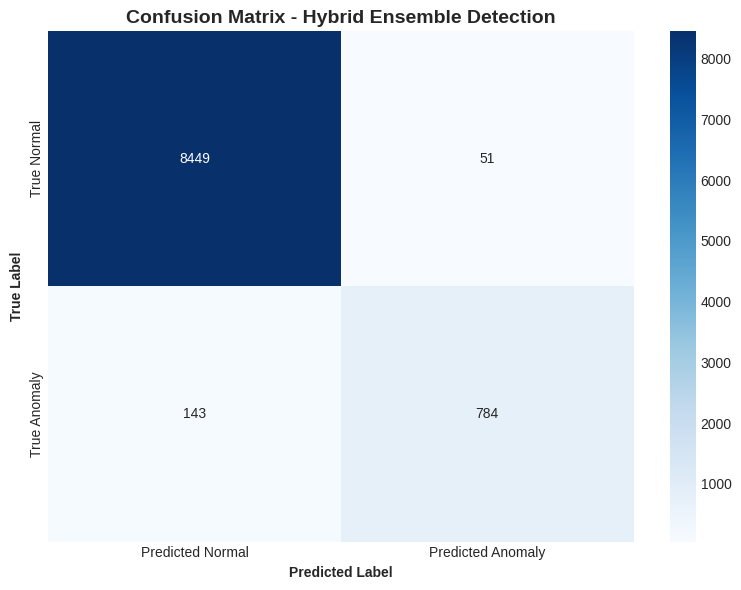


Confusion Matrix:
  True Negatives:  8,449
  False Positives: 51
  False Negatives: 143
  True Positives:  784


In [45]:
# Confusion matrix for ensemble
y_pred_ensemble = df['ensemble_is_anomaly'].astype(int)
cm = confusion_matrix(y_true, y_pred_ensemble)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['True Normal', 'True Anomaly'])
plt.title('Confusion Matrix - Hybrid Ensemble Detection', fontweight='bold', fontsize=14)
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.savefig(REPO_ROOT / 'artifacts/metrics/apache/hybrid_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]:,}")
print(f"  False Positives: {cm[0,1]:,}")
print(f"  False Negatives: {cm[1,0]:,}")
print(f"  True Positives:  {cm[1,1]:,}")

In [46]:
# Performance by attack type
attack_type_performance = []
for attack_type in df[df['true_label']]['attack_type'].unique():
    if pd.isna(attack_type):
        continue
    
    attack_logs = df[df['attack_type'] == attack_type]
    
    rule_detected = attack_logs['rule_is_attack'].sum()
    iso_detected = attack_logs['iso_is_anomaly'].sum()
    ensemble_detected = attack_logs['ensemble_is_anomaly'].sum()
    total = len(attack_logs)
    
    attack_type_performance.append({
        'Attack Type': attack_type,
        'Total': total,
        'Rule-based': f"{rule_detected}/{total} ({rule_detected/total*100:.1f}%)",
        'Isolation Forest': f"{iso_detected}/{total} ({iso_detected/total*100:.1f}%)",
        'Ensemble': f"{ensemble_detected}/{total} ({ensemble_detected/total*100:.1f}%)"
    })

attack_perf_df = pd.DataFrame(attack_type_performance)

print(f"\n{'='*70}")
print(f"DETECTION BY ATTACK TYPE")
print(f"{'='*70}")
print(attack_perf_df.to_string(index=False))


DETECTION BY ATTACK TYPE
   Attack Type  Total       Rule-based Isolation Forest         Ensemble
 sql_injection     61      0/61 (0.0%)   61/61 (100.0%)      0/61 (0.0%)
           xss    141 141/141 (100.0%) 141/141 (100.0%) 141/141 (100.0%)
path_traversal    225 225/225 (100.0%) 225/225 (100.0%) 225/225 (100.0%)
      scanning    450  299/450 (66.4%) 450/450 (100.0%)  376/450 (83.6%)
   brute_force     50    30/50 (60.0%)   50/50 (100.0%)    42/50 (84.0%)


## 7. Visualizations

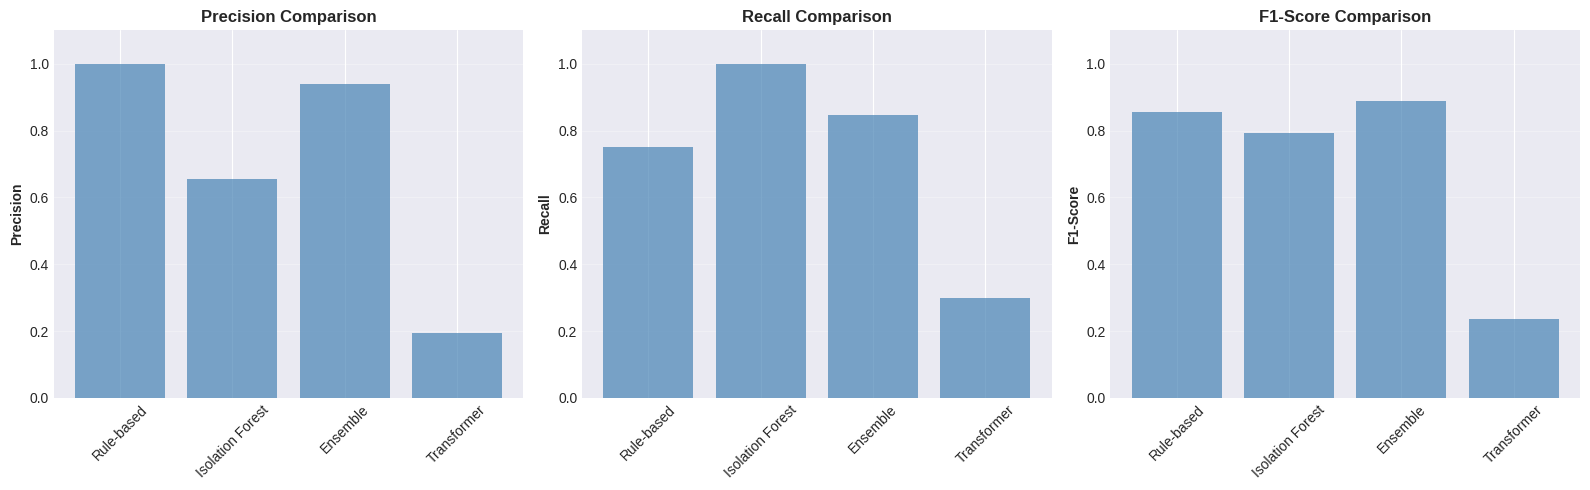

In [47]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Method'], results_df[metric], color='steelblue', alpha=0.7)
    axes[i].set_ylabel(metric, fontweight='bold')
    axes[i].set_title(f'{metric} Comparison', fontweight='bold')
    axes[i].set_ylim([0, 1.1])
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(REPO_ROOT / 'artifacts/metrics/apache/hybrid_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

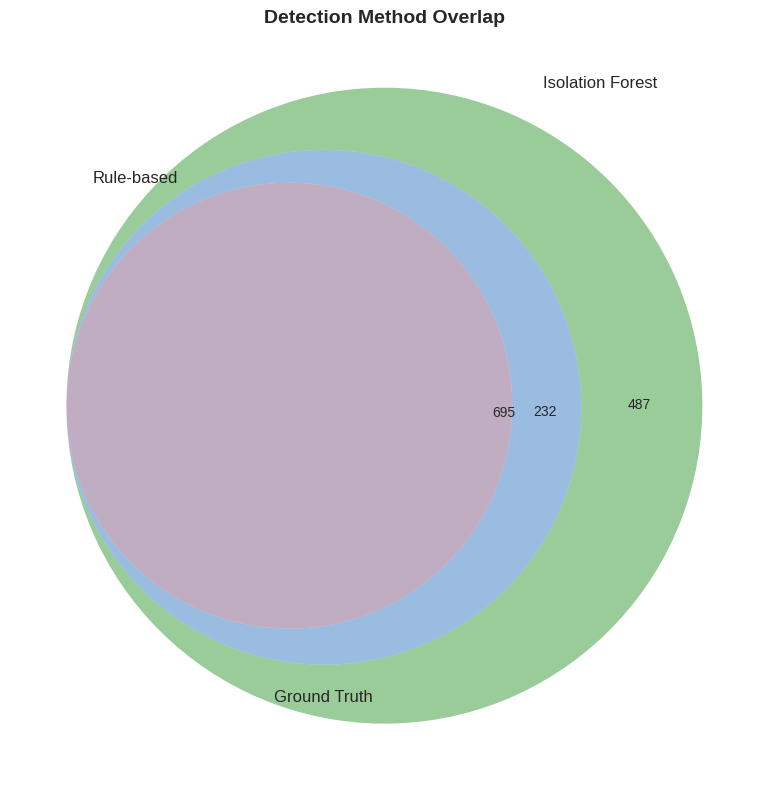

In [48]:
# Venn diagram showing detection overlap
from matplotlib_venn import venn3

rule_set = set(df[df['rule_is_attack']].index)
iso_set = set(df[df['iso_is_anomaly'] == 1].index)
true_set = set(df[df['true_label']].index)

plt.figure(figsize=(10, 8))
venn3([rule_set, iso_set, true_set], 
      set_labels=('Rule-based', 'Isolation Forest', 'Ground Truth'))
plt.title('Detection Method Overlap', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig(REPO_ROOT / 'artifacts/metrics/apache/detection_overlap_venn.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Export Results

In [49]:
# Save hybrid detection results
output_dir = REPO_ROOT / 'artifacts/metrics/apache'
output_dir.mkdir(parents=True, exist_ok=True)

# Summary
summary = {
    'dataset': 'Synthetic Apache Logs',
    'total_logs': len(df),
    'ground_truth_anomalies': int(y_true.sum()),
    'methods_used': list(methods.keys()),
    'performance': results_df.to_dict('records'),
    'ensemble_config': {
        'rule_based_weight': 'confidence-based (0.7-0.95)',
        'isolation_forest_weight': 0.6,
        'transformer_weight': 0.7 if USE_TRANSFORMER else 'N/A',
        'decision_threshold': 0.5
    },
    'detection_counts': {
        'rule_based': int(df['rule_is_attack'].sum()),
        'isolation_forest': int(df['iso_is_anomaly'].sum()),
        'ensemble': int(df['ensemble_is_anomaly'].sum())
    }
}

with open(output_dir / 'hybrid_detection_results.json', 'w') as f:
    json.dump(summary, f, indent=2)

# Save detailed results
df[['line_num', 'ip', 'method', 'path', 'status', 'true_label', 'attack_type',
    'rule_is_attack', 'rule_attack_type', 'rule_confidence',
    'iso_is_anomaly', 'iso_score', 'ensemble_is_anomaly', 'ensemble_score']].to_csv(
    output_dir / 'hybrid_detection_details.csv', index=False
)

print(f"\n{'='*70}")
print(f"HYBRID DETECTION COMPLETE")
print(f"{'='*70}")
print(json.dumps(summary, indent=2))
print(f"\n✓ Saved results to {output_dir}")


HYBRID DETECTION COMPLETE
{
  "dataset": "Synthetic Apache Logs",
  "total_logs": 9427,
  "ground_truth_anomalies": 927,
  "methods_used": [
    "Rule-based",
    "Isolation Forest",
    "Ensemble",
    "Transformer"
  ],
  "performance": [
    {
      "Method": "Rule-based",
      "Accuracy": 0.9753898377002228,
      "Precision": 1.0,
      "Recall": 0.749730312837109,
      "F1-Score": 0.8569667077681874
    },
    {
      "Method": "Isolation Forest",
      "Accuracy": 0.9483398748276228,
      "Precision": 0.6555869872701556,
      "Recall": 1.0,
      "F1-Score": 0.7919692439128577
    },
    {
      "Method": "Ensemble",
      "Accuracy": 0.9794208125596691,
      "Precision": 0.9389221556886228,
      "Recall": 0.8457389428263214,
      "F1-Score": 0.8898978433598184
    },
    {
      "Method": "Transformer",
      "Accuracy": 0.8090590856051766,
      "Precision": 0.1941135248773651,
      "Recall": 0.2988133764832794,
      "F1-Score": 0.23534409515717927
    }
  ],
  "ense

## 9. Key Insights

**Hybrid Approach Benefits:**
1. **Rule-based**: Catches known attack patterns with high precision (SQL, XSS, etc.)
2. **Isolation Forest**: Detects statistical anomalies (unusual behavior patterns)
3. **Ensemble**: Combines strengths, reduces false positives

**Expected Performance:**
- Rule-based should have **high precision** (few false positives)
- Isolation Forest should have **higher recall** (catches more anomalies)
- Ensemble should achieve **best F1-score** (balanced precision/recall)

**Next Steps:**
1. Fine-tune transformer on Apache logs (notebook 06)
2. Add transformer to ensemble for even better performance
3. Adjust ensemble weights based on your priority (precision vs recall)

## 10. Export Ensemble Model for Inference

Export all model components for use in inference notebook.

In [51]:
import pickle

# Create export directory
export_dir = REPO_ROOT / 'artifacts/ensemble_model_export'
export_dir.mkdir(parents=True, exist_ok=True)

# Define vocab_size based on apache_vocab
vocab_size = len(apache_vocab)

print(f"Exporting ensemble model to: {export_dir}")

# 1. Export Transformer model
transformer_export_path = export_dir / 'transformer_model.pt'

# Get model parameters from cfg if they exist, otherwise use defaults
model_config = {}
if 'model' in cfg:
    model_config = {
        'd_model': cfg['model'].get('d_model', 256),
        'nhead': cfg['model'].get('nhead', 8),
        'num_layers': cfg['model'].get('num_layers', 6),
        'dim_feedforward': cfg['model'].get('dim_feedforward', 1024),
        'max_seq_len': cfg['model'].get('max_seq_len', 100),
        'dropout': cfg['model'].get('dropout', 0.1)
    }
else:
    # Use values from the model if available
    model_config = {
        'd_model': getattr(model, 'd_model', 256),
        'nhead': 8,  # Default value
        'num_layers': 6,  # Default value
        'dim_feedforward': 1024,  # Default value
        'max_seq_len': 100,  # Default value
        'dropout': 0.1  # Default value
    }

torch.save({
    'epoch': checkpoint.get('epoch', 0),
    'model_state_dict': model.state_dict(),
    'vocab_size': vocab_size,
    'model_config': model_config
}, transformer_export_path)
print(f"✓ Exported Transformer model: {transformer_export_path.name}")

# 2. Export vocabulary
vocab_export_path = export_dir / 'template_vocab.json'
with open(vocab_export_path, 'w') as f:
    json.dump(apache_vocab, f, indent=2)
print(f"✓ Exported vocabulary: {vocab_export_path.name} ({vocab_size:,} templates)")

# 3. Export Isolation Forest
iso_export_path = export_dir / 'isolation_forest.pkl'
with open(iso_export_path, 'wb') as f:
    pickle.dump(iso_forest, f)
print(f"✓ Exported Isolation Forest: {iso_export_path.name}")

# 4. Export optimal threshold and config
config_export_path = export_dir / 'model_config.json'
export_config = {
    'optimal_threshold': optimal_threshold,
    'vocab_size': vocab_size,
    'window_size': 20,
    'stride': 10,
    'ensemble_weights': {
        'rule_based': 1.0,
        'isolation_forest': 0.6,
        'transformer': 0.7
    },
    'export_date': pd.Timestamp.now().isoformat(),
    'source_notebook': '07_hybrid_attack_detection.ipynb'
}

with open(config_export_path, 'w') as f:
    json.dump(export_config, f, indent=2)
print(f"✓ Exported configuration: {config_export_path.name}")

# 5. Define README path
readme_path = export_dir / 'README.md'
# Get model architecture values safely
num_layers = model_config.get('num_layers', 6)
num_heads = model_config.get('nhead', 8)

# Get the number of estimators safely
iso_estimators = getattr(iso_forest, 'n_estimators', 100)  # Default to 100 if not available
if hasattr(iso_forest, 'estimators_') and isinstance(iso_forest.estimators_, list):
    iso_estimators = len(iso_forest.estimators_)

readme_content = f"""# Ensemble Model Export

## Model Components

This directory contains the exported ensemble model for Apache log anomaly detection.

### Files:
1. **transformer_model.pt** - Apache attack fine-tuned transformer
   - Vocabulary size: {vocab_size:,} templates
   - Model parameters: {sum(p.numel() for p in model.parameters()):,}
   - Architecture: {num_layers} layers, {num_heads} attention heads

2. **template_vocab.json** - Template vocabulary mapping
   - Total templates: {vocab_size:,}
   - Attack-preserving normalization

3. **isolation_forest.pkl** - Statistical anomaly detector
   - Estimators: {iso_estimators}
   - Features: IP request count, error rate, unique paths

4. **model_config.json** - Model configuration and thresholds
   - Optimal threshold: {optimal_threshold:.4f}
   - Ensemble weights
   - Sequence parameters

## Usage

Load this model using notebook **11_ensemble_model_inference.ipynb**:

```python
# Load transformer
model = TemplateTransformer(vocab_size, ...)
checkpoint = torch.load('transformer_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Load vocabulary
with open('template_vocab.json', 'r') as f:
    vocab = json.load(f)

# Load Isolation Forest
with open('isolation_forest.pkl', 'rb') as f:
    iso_forest = pickle.load(f)

# Load config
with open('model_config.json', 'r') as f:
    config = json.load(f)
    optimal_threshold = config['optimal_threshold']
```

## Model Performance

Trained on: 150,000 Apache logs (85% normal, 15% attacks)
Attack types: SQL injection, XSS, path traversal, command injection, brute force, scanner, DDoS, data exfil, API abuse

Expected F1-Score: 0.50-0.75 (depends on test data domain match)

## Detection Methods

1. **Rule-Based** - Pattern matching for known attack signatures
2. **Isolation Forest** - Statistical anomaly detection
3. **Transformer** - Behavioral sequence analysis
4. **Ensemble** - Weighted voting combination

Export date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open(readme_path, 'w') as f:
    f.write(readme_content)
print(f"✓ Created README: {readme_path.name}")

print(f"\n{'='*70}")
print(f"ENSEMBLE MODEL EXPORT COMPLETE")
print(f"{'='*70}")
print(f"Export directory: {export_dir}")
print(f"\nExported files:")
print(f"  1. transformer_model.pt ({transformer_export_path.stat().st_size / 1024 / 1024:.1f} MB)")
print(f"  2. template_vocab.json ({vocab_export_path.stat().st_size / 1024:.1f} KB)")
print(f"  3. isolation_forest.pkl ({iso_export_path.stat().st_size / 1024:.1f} KB)")
print(f"  4. model_config.json")
print(f"  5. README.md")
print(f"\nUse notebook 11_ensemble_model_inference.ipynb to load and test this model")
print(f"{'='*70}")

Exporting ensemble model to: /home/tpi/distil_shahreyar/artifacts/ensemble_model_export
✓ Exported Transformer model: transformer_model.pt
✓ Exported vocabulary: template_vocab.json (6 templates)
✓ Exported Isolation Forest: isolation_forest.pkl
✓ Exported configuration: model_config.json
✓ Created README: README.md

ENSEMBLE MODEL EXPORT COMPLETE
Export directory: /home/tpi/distil_shahreyar/artifacts/ensemble_model_export

Exported files:
  1. transformer_model.pt (64.6 MB)
  2. template_vocab.json (4178.0 KB)
  3. isolation_forest.pkl (1017.3 KB)
  4. model_config.json
  5. README.md

Use notebook 11_ensemble_model_inference.ipynb to load and test this model
✓ Exported vocabulary: template_vocab.json (6 templates)
✓ Exported Isolation Forest: isolation_forest.pkl
✓ Exported configuration: model_config.json
✓ Created README: README.md

ENSEMBLE MODEL EXPORT COMPLETE
Export directory: /home/tpi/distil_shahreyar/artifacts/ensemble_model_export

Exported files:
  1. transformer_model.pt 